In [1]:
import boto3
import pandas as pd
import numpy as np
import os
from datetime import datetime
import requests
import zipfile
import io
import re
import time
import urllib.parse

In [2]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'ap-south-1',
    aws_access_key_id='AKIAQ----------HT5W5',
    aws_secret_access_key = 'upWVXX6-----ucuZu72IH-----78CeMwb---jxka'
)

In [3]:
for bucket in s3.buckets.all():
    print(bucket.name)

portfolio-return-data
portfolio-return-raw-bucket


### 1. Data Ingestion : 
    a. Download raw data from source.
    b. Extract
    c. Parse the files into structured format

In [4]:
def get_zip_links():
    years = range(2017, 2026)
    base = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives"

    links = []
    for y in years:
        folder = f"08 {y} Update"
        for ext in ["TXT"]:
            url = f"{base}/{folder}/ftp/6_Portfolios_2x3_{ext}.zip"
            links.append(url)

    return links

zip_links = get_zip_links()
zip_links

['https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2017 Update/ftp/6_Portfolios_2x3_TXT.zip',
 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2018 Update/ftp/6_Portfolios_2x3_TXT.zip',
 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2019 Update/ftp/6_Portfolios_2x3_TXT.zip',
 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2020 Update/ftp/6_Portfolios_2x3_TXT.zip',
 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2021 Update/ftp/6_Portfolios_2x3_TXT.zip',
 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2022 Update/ftp/6_Portfolios_2x3_TXT.zip',
 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2023 Update/ftp/6_Portfolios_2x3_TXT.zip',
 'https://mba.tuck.dartmouth.edu/pages/fa

In [5]:
output_dir = r"C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv"
os.makedirs(output_dir, exist_ok=True)

markers = [
    "Average Value Weighted Returns -- Monthly",
    "Average Equal Weighted Returns -- Monthly",
    "Average Value Weighted Returns -- Annual"
]

def parse_fama_french_text(text):
    lines = text.splitlines()
    positions = {}

    for i, line in enumerate(lines):
        for m in markers:
            if m in line:
                positions[m] = i

    tables = {}
    marker_list = sorted(positions.items(), key=lambda x: x[1])

    for idx in range(len(marker_list)-1):
        name, start = marker_list[idx]
        _, end = marker_list[idx + 1]

        block = lines[start + 2:end]
        rows = []

        for line in block:
            parts = line.strip().split()
            if parts and parts[0].isdigit():
                rows.append(parts)

        if rows:
            df = pd.DataFrame(rows, columns=[
                "Date",
                "Small_Low", "Small_2", "Small_High",
                "Big_Low", "Big_2", "Big_High"
            ])

            for col in df.columns[1:]:
                df[col] = pd.to_numeric(df[col], errors="coerce")

            df["Date"] = pd.to_datetime(df["Date"], format="%Y%m", errors="coerce")
            tables[name] = df

    return tables

# MAIN LOOP
for url in zip_links:
    print(f"Processing: {url}")

    response = requests.get(url, verify=False)
    zip_bytes = io.BytesIO(response.content)

    with zipfile.ZipFile(zip_bytes) as z:
        txt_files = [f for f in z.namelist() if f.endswith(".txt")]
        if not txt_files:
            print("No txt file found inside ZIP:", url)
            continue

        txt_filename = txt_files[0]
        text_data = z.read(txt_filename).decode("latin-1")

    # Parse tables
    tables = parse_fama_french_text(text_data)

    year_match = re.search(r"/.*?(\d{4}).*?/", url)
    if year_match:
        year = year_match.group(1)
    else:
        print("Could not extract year → skipping:", url)
        continue
    
    year_folder = os.path.join(output_dir, year)
    os.makedirs(year_folder, exist_ok=True)


    # Save CSV files inside YEAR folder
    for name, df in tables.items():
        clean_name = name.replace(" ", "_").replace("-", "")
        csv_path = os.path.join(year_folder, f"{clean_name}.csv")

        df.to_csv(csv_path, index=False)
        print(f"Saved → {csv_path}")

print("\nAll files processed successfully")


Processing: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2017 Update/ftp/6_Portfolios_2x3_TXT.zip


C:\Users\nshinga\without_conda\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Processing: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2018 Update/ftp/6_Portfolios_2x3_TXT.zip


C:\Users\nshinga\without_conda\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2018\Average_Value_Weighted_Returns__Monthly.csv
Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2018\Average_Equal_Weighted_Returns__Monthly.csv
Processing: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2019 Update/ftp/6_Portfolios_2x3_TXT.zip


C:\Users\nshinga\without_conda\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2019\Average_Value_Weighted_Returns__Monthly.csv
Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2019\Average_Equal_Weighted_Returns__Monthly.csv
Processing: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2020 Update/ftp/6_Portfolios_2x3_TXT.zip


C:\Users\nshinga\without_conda\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2020\Average_Value_Weighted_Returns__Monthly.csv
Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2020\Average_Equal_Weighted_Returns__Monthly.csv
Processing: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2021 Update/ftp/6_Portfolios_2x3_TXT.zip


C:\Users\nshinga\without_conda\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2021\Average_Value_Weighted_Returns__Monthly.csv
Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2021\Average_Equal_Weighted_Returns__Monthly.csv
Processing: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2022 Update/ftp/6_Portfolios_2x3_TXT.zip


C:\Users\nshinga\without_conda\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2022\Average_Value_Weighted_Returns__Monthly.csv
Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2022\Average_Equal_Weighted_Returns__Monthly.csv
Processing: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2023 Update/ftp/6_Portfolios_2x3_TXT.zip


C:\Users\nshinga\without_conda\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2023\Average_Value_Weighted_Returns__Monthly.csv
Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2023\Average_Equal_Weighted_Returns__Monthly.csv
Processing: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2024 Update/ftp/6_Portfolios_2x3_TXT.zip


C:\Users\nshinga\without_conda\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2024\Average_Value_Weighted_Returns__Monthly.csv
Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2024\Average_Equal_Weighted_Returns__Monthly.csv
Processing: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/Historical_Archives/08 2025 Update/ftp/6_Portfolios_2x3_TXT.zip


C:\Users\nshinga\without_conda\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mba.tuck.dartmouth.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2025\Average_Value_Weighted_Returns__Monthly.csv
Saved → C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2025\Average_Equal_Weighted_Returns__Monthly.csv

All files processed successfully


##### upload data to s3

In [6]:
local_base_dir = r"C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv"
bucket_name = "portfolio-return-data"   
s3_prefix = "ff_6_portfolios/output_csv"       

for root, dirs, files in os.walk(local_base_dir):
    for file in files:
        if file.endswith(".csv"):
            local_path = os.path.join(root, file)

            rel_path = os.path.relpath(local_path, local_base_dir)
            s3_key = os.path.join(s3_prefix, rel_path).replace("\\", "/")

            print(f"Uploading {local_path} → s3://{bucket_name}/{s3_key}")
            s3.Bucket('portfolio-return-data').upload_file(local_path, s3_key)

print("Upload complete")

Uploading C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2018\Average_Equal_Weighted_Returns__Monthly.csv → s3://portfolio-return-data/ff_6_portfolios/output_csv/2018/Average_Equal_Weighted_Returns__Monthly.csv
Uploading C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2018\Average_Value_Weighted_Returns__Monthly.csv → s3://portfolio-return-data/ff_6_portfolios/output_csv/2018/Average_Value_Weighted_Returns__Monthly.csv
Uploading C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2019\Average_Equal_Weighted_Returns__Monthly.csv → s3://portfolio-return-data/ff_6_portfolios/output_csv/2019/Average_Equal_Weighted_Returns__Monthly.csv
Uploading C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv\2019\Average_Value_Weighted_Returns__Monthly.csv → s3://portfolio-return-data/ff_6_portfolios/output_csv/2019/Average_Value_Weighted_Returns__Monthly.

### 2. Transform to Long Format

In [7]:
main_path = r"C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\output_csv"

raw_data_list = []
ingestion_map_list = []

for root, dirs, files in os.walk(main_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            
            # Convert to long format
            df = df.melt(id_vars=df.columns[0], var_name='PORTFOLIO', value_name='RETURN')
            
            # Convert date column to datetime
            df[df.columns[0]] = pd.to_datetime(df[df.columns[0]], format='%Y-%m-%d', errors='coerce')
            df.rename(columns={df.columns[0]: 'DATE'}, inplace=True)
            
            # Add metadata
            df['SOURCE'] = file_path
            df['INGESTION_TIME'] = datetime.now()
            df['INGESTED_BY'] = 'Neha Shingare'
            df['INGESTED_SYSTEM'] = 'Python_Local'
            
            raw_data_list.append(df)
            
            # Record ingestion map
            ingestion_map_list.append({
                'FILE_NAME': file,
                'YEAR_FOLDER': os.path.basename(root),
                'INGESTION_TIME': datetime.now(),
                'RECORDS_INGESTED': len(df)
            })

### 3. Access method and Source Map Table

In [8]:
%%time
RAW_DATA = pd.concat(raw_data_list, ignore_index=True)
DATA_INGESTION_MAP = pd.DataFrame(ingestion_map_list)

# Cleaning data
RAW_DATA['DATE'] = pd.to_datetime(RAW_DATA['DATE'])
RAW_DATA['RETURN'] = pd.to_numeric(RAW_DATA['RETURN'], errors='coerce')

# handling nulls & duplicates
RAW_DATA.dropna(subset=['DATE', 'PORTFOLIO', 'RETURN'], inplace=True)
RAW_DATA.drop_duplicates(inplace=True)


pit_data_list = []
for year in range(2017, 2026):
    pit_df = RAW_DATA[RAW_DATA['DATE'] <= pd.Timestamp(year=year, month=7, day=31)].copy()
    pit_df['PIT_YEAR'] = year
    pit_data_list.append(pit_df)
PIT_DATA = pd.concat(pit_data_list, ignore_index=True)

# CURRENT_DATA = RAW_DATA.copy()
CURRENT_DATA = RAW_DATA.loc[RAW_DATA.groupby('PORTFOLIO')['DATE'].idxmax()].reset_index(drop=True)

output_path = r"C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\processed_output"
os.makedirs(output_path, exist_ok=True)

RAW_DATA.to_csv(os.path.join(output_path, 'RAW_DATA.csv'), index=False)
PIT_DATA.to_csv(os.path.join(output_path, 'PIT_DATA.csv'), index=False)
CURRENT_DATA.to_csv(os.path.join(output_path, 'CURRENT_DATA.csv'), index=False)
DATA_INGESTION_MAP.to_csv(os.path.join(output_path, 'DATA_INGESTION_MAP.csv'), index=False)

print("Data processing complete")

Data processing complete
CPU times: total: 10.1 s
Wall time: 27.6 s


In [9]:
RAW_DATA.shape, PIT_DATA.shape, CURRENT_DATA.shape

((110112, 7), (973728, 8), (6, 7))

### 4. Upload data to S3

In [10]:
%%time
local_dir = r"C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\processed_output"
bucket_name = "portfolio-return-data"   
s3_prefix = "ff_6_portfolios/processed_output/"       


for file in os.listdir(local_dir):
    if file.endswith(".csv"):
        local_path = os.path.join(local_dir, file)
        s3_key = os.path.join(s3_prefix, file).replace("\\", "/")

        print(f"Uploading {local_path} → s3://{bucket_name}/{s3_key}")
        s3.Bucket('portfolio-return-data').upload_file(local_path, s3_key)

print("Upload complete")

Uploading C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\processed_output\CURRENT_DATA.csv → s3://portfolio-return-data/ff_6_portfolios/processed_output/CURRENT_DATA.csv
Uploading C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\processed_output\DATA_INGESTION_MAP.csv → s3://portfolio-return-data/ff_6_portfolios/processed_output/DATA_INGESTION_MAP.csv
Uploading C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\processed_output\PIT_DATA.csv → s3://portfolio-return-data/ff_6_portfolios/processed_output/PIT_DATA.csv
Uploading C:\Users\nshinga\OneDrive - MORNINGSTAR INC\Neha\Assessment\ff_6_portfolios\processed_output\RAW_DATA.csv → s3://portfolio-return-data/ff_6_portfolios/processed_output/RAW_DATA.csv
Upload complete
CPU times: total: 12.8 s
Wall time: 28.2 s


#### Data quality check

In [21]:
def robustness_checks(df_raw):
    print("1. NULL CHECKS")
    null_counts = df_raw.isnull().sum()
    print(null_counts)
    print("\n")

    print("2. DUPLICATE CHECKS")
    dup_count = df_raw.duplicated().sum()
    print(f"Total duplicated rows: {dup_count}")
    if dup_count > 0:
        print("Removing duplicates...")
        df_raw.drop_duplicates(inplace=True)
    print("\n")

    print("3. SCHEMA & DTYPE VALIDATION")
    expected_columns = ['DATE', 'PORTFOLIO', 'RETURN', 'SOURCE', 'INGESTION_TIME', 'INGESTED_BY', 'INGESTED_SYSTEM']

    missing_cols = [col for col in expected_columns if col not in df_raw.columns]
    if missing_cols:
        print(f"Missing required columns: {missing_cols}")
    else:
        print("All required columns present")

    # enforce types
    try:
        df_raw['DATE'] = pd.to_datetime(df_raw['DATE'])
        print("DATE converted to datetime")
    except:
        print("Failed to convert DATE to datetime")

    try:
        df_raw['RETURN'] = pd.to_numeric(df_raw['RETURN'], errors='coerce')
        print("RETURN converted to numeric")
    except:
        print("Failed to convert RETURN to numeric")

    print("\n")

    print("4. DATE RANGE VALIDATION")
    min_date = df_raw['DATE'].min()
    max_date = df_raw['DATE'].max()
    print(f"Earliest DATE: {min_date}")
    print(f"Latest DATE:   {max_date}")

    # Business rule: Data must be >= July 2017
    cutoff_date = pd.Timestamp("2017-07-01")

    if min_date < cutoff_date:
        print(f"Some dates earlier than July 2017 found: {min_date}")
    else:
        print("No dates before July 2017")

    # No future dates allowed
    today = pd.Timestamp.today()
    if max_date > today:
        print(f"Future dates detected: {max_date}")
    else:
        print("No future dates detected")
    print("\n")

    print("5. MONTHLY CONTINUITY CHECK")
    expected_months = pd.date_range(start=min_date, end=max_date, freq='MS')
    actual_months = df_raw['DATE'].dt.to_period('M').unique()

    missing_months = set(expected_months.to_period('M')) - set(actual_months)

    if missing_months:
        print(f"Missing months: {sorted(missing_months)}")
    else:
        print("No missing months in the dataset")
    print("\n")

    
    print("6. PORTFOLIO VALIDATION")
    allowed_prefixes = ['SL', 'SM', 'SH', 'BL', 'BM', 'BH', 'Bi','Sm']  # Example for 6 FF portfolios

    invalid_portfolios = df_raw[~df_raw['PORTFOLIO'].str[:2].isin([x[:2] for x in allowed_prefixes])]['PORTFOLIO'].unique()

    if len(invalid_portfolios) > 0:
        print(f"Unexpected portfolio labels found: {invalid_portfolios}")
    else:
        print("Portfolio labels follow expected pattern")
    print("\n")


    print("7. RETURN VALUE VALIDATION")
    if df_raw['RETURN'].isnull().sum() > 0:
        print(f"⚠ RETURN contains {df_raw['RETURN'].isnull().sum()} null values")
    
    if not df_raw['RETURN'].between(-100, 100).all():  
        print("Some RETURN values fall outside typical % return bounds (-100 to 100)")
    else:
        print("RETURN values within reasonable range")
    print("\n")


    print("8. PIT (Point-In-Time) INTEGRITY CHECK")
    # Example: ensure PIT cutoff logic holds:
    # PIT for year X should only contain dates <= July of year X
    try:
        PIT_DATA  # check if exists
        for year in range(2017, 2026):
            pit_violations = df_raw[df_raw['DATE'] > pd.Timestamp(year=year, month=7, day=31)]

        if len(pit_violations) > 0:
            print("PIT dataset contains rows beyond PIT cutoff.")
        else:
            print("PIT dataset passes integrity checks")
    except:
        print("PIT dataset not loaded in this environment")
    print("\n")


    print("9. S3 UPLOAD CHECK (Optional)")
    s3 = boto3.client(
        service_name = 's3',
        region_name = 'ap-south-1',
        aws_access_key_id='AKIAQ----------HT5W5',
        aws_secret_access_key = 'upWVXX6-----ucuZu72IH-----78CeMwb---jxka'
    )
    
    bucket_name = 'portfolio-return-data'
    s3_path_prefix = 'ff_6_portfolios/processed_output/'
    
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_path_prefix)
    
    if 'Contents' in response:
        print(f"Files in '{s3_path_prefix}':")
        for obj in response['Contents']:
            print(obj['Key'])
    else:
        print(f"No files found in '{s3_path_prefix}' in bucket '{bucket_name}'.")
    

    return df_raw


In [22]:
df_raw_checked = robustness_checks(CURRENT_DATA)

1. NULL CHECKS
DATE               0
PORTFOLIO          0
RETURN             0
SOURCE             0
INGESTION_TIME     0
INGESTED_BY        0
INGESTED_SYSTEM    0
dtype: int64


2. DUPLICATE CHECKS
Total duplicated rows: 0


3. SCHEMA & DTYPE VALIDATION
All required columns present
DATE converted to datetime
RETURN converted to numeric


4. DATE RANGE VALIDATION
Earliest DATE: 2025-07-01 00:00:00
Latest DATE:   2025-07-01 00:00:00
No dates before July 2017
No future dates detected


5. MONTHLY CONTINUITY CHECK
No missing months in the dataset


6. PORTFOLIO VALIDATION
Portfolio labels follow expected pattern


7. RETURN VALUE VALIDATION
RETURN values within reasonable range


8. PIT (Point-In-Time) INTEGRITY CHECK
PIT dataset passes integrity checks


9. S3 UPLOAD CHECK (Optional)
Files in 'ff_6_portfolios/processed_output/':
ff_6_portfolios/processed_output/CURRENT_DATA.csv
ff_6_portfolios/processed_output/DATA_INGESTION_MAP.csv
ff_6_portfolios/processed_output/PIT_DATA.csv
ff_6_portfo

In [23]:
df_raw_checked = robustness_checks(RAW_DATA)

1. NULL CHECKS
DATE               0
PORTFOLIO          0
RETURN             0
SOURCE             0
INGESTION_TIME     0
INGESTED_BY        0
INGESTED_SYSTEM    0
dtype: int64


2. DUPLICATE CHECKS
Total duplicated rows: 0


3. SCHEMA & DTYPE VALIDATION
All required columns present
DATE converted to datetime
RETURN converted to numeric


4. DATE RANGE VALIDATION
Earliest DATE: 1926-07-01 00:00:00
Latest DATE:   2025-07-01 00:00:00
Some dates earlier than July 2017 found: 1926-07-01 00:00:00
No future dates detected


5. MONTHLY CONTINUITY CHECK
No missing months in the dataset


6. PORTFOLIO VALIDATION
Portfolio labels follow expected pattern


7. RETURN VALUE VALIDATION
RETURN values within reasonable range


8. PIT (Point-In-Time) INTEGRITY CHECK
PIT dataset passes integrity checks


9. S3 UPLOAD CHECK (Optional)
Files in 'ff_6_portfolios/processed_output/':
ff_6_portfolios/processed_output/CURRENT_DATA.csv
ff_6_portfolios/processed_output/DATA_INGESTION_MAP.csv
ff_6_portfolios/proces

In [24]:
df_raw_checked = robustness_checks(PIT_DATA)

1. NULL CHECKS
DATE               0
PORTFOLIO          0
RETURN             0
SOURCE             0
INGESTION_TIME     0
INGESTED_BY        0
INGESTED_SYSTEM    0
PIT_YEAR           0
dtype: int64


2. DUPLICATE CHECKS
Total duplicated rows: 0


3. SCHEMA & DTYPE VALIDATION
All required columns present
DATE converted to datetime
RETURN converted to numeric


4. DATE RANGE VALIDATION
Earliest DATE: 1926-07-01 00:00:00
Latest DATE:   2025-07-01 00:00:00
Some dates earlier than July 2017 found: 1926-07-01 00:00:00
No future dates detected


5. MONTHLY CONTINUITY CHECK
No missing months in the dataset


6. PORTFOLIO VALIDATION
Portfolio labels follow expected pattern


7. RETURN VALUE VALIDATION
RETURN values within reasonable range


8. PIT (Point-In-Time) INTEGRITY CHECK
PIT dataset passes integrity checks


9. S3 UPLOAD CHECK (Optional)
Files in 'ff_6_portfolios/processed_output/':
ff_6_portfolios/processed_output/CURRENT_DATA.csv
ff_6_portfolios/processed_output/DATA_INGESTION_MAP.csv
f

In [25]:
database_name = "ff_6_portfolios"
s3_data_location = "s3://portfolio-return-data/ff_6_portfolios/processed_output/"
s3_output = "s3://portfolio-return-data/athena-query-results/"  # Athena query results

athena_client = boto3.client(
    service_name = 'athena',
    region_name = 'ap-south-1',
    aws_access_key_id='AKIAQ----------HT5W5',
    aws_secret_access_key = 'upWVXX6-----ucuZu72IH-----78CeMwb---jxka'
)

s3_client = boto3.client(
    service_name = 's3',
    region_name = 'ap-south-1',
    aws_access_key_id='AKIAQ----------HT5W5',
    aws_secret_access_key = 'upWVXX6-----ucuZu72IH-----78CeMwb---jxka'
)

def wait_for_query(query_execution_id):
    while True:
        response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
        status = response['QueryExecution']['Status']['State']
        if status in ["SUCCEEDED", "FAILED", "CANCELLED"]:
            break
        time.sleep(2)
    return status


# Create database
query = f"""
CREATE DATABASE IF NOT EXISTS {database_name}
LOCATION '{s3_data_location}'
"""
response = athena_client.start_query_execution(
    QueryString=query,
    ResultConfiguration={"OutputLocation": s3_output}
)
wait_for_query(response["QueryExecutionId"])
print(f"Database '{database_name}' ensured.")


# List CSV files in S3 folder
parsed_url = urllib.parse.urlparse(s3_data_location)
bucket = parsed_url.netloc
prefix = parsed_url.path.lstrip("/")

csv_objects = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
csv_files = [obj['Key'] for obj in csv_objects.get('Contents', []) if obj['Key'].endswith('.csv')]

if not csv_files:
    print("No CSV files found in the specified S3 folder.")
    exit()

# Create tables from CSVs
for csv_file in csv_files:
    table_name = csv_file.split("/")[-1].replace(".csv", "").replace("-", "_")
    
    obj = s3_client.get_object(Bucket=bucket, Key=csv_file)
    df = pd.read_csv(io.BytesIO(obj['Body'].read()), nrows=5)
    
    columns = ",\n    ".join([f"{col.replace(' ', '_')} string" for col in df.columns])
    
    # Location = parent folder, not the file itself
    s3_file_folder = s3_data_location  # points to folder, not individual file
    
    create_table_query = f"""
    CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
        {columns}
    )
    ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES (
        'serialization.format' = ',',
        'field.delim' = ','
    )
    STORED AS TEXTFILE
    LOCATION '{s3_file_folder}'
    TBLPROPERTIES ('has_encrypted_data'='false');
    """
    
    response = athena_client.start_query_execution(
        QueryString=create_table_query,
        ResultConfiguration={"OutputLocation": s3_output}
    )
    
    status = wait_for_query(response["QueryExecutionId"])
    if status == "SUCCEEDED":
        print(f"Table '{table_name}' created successfully.")
    else:
        print(f"Failed to create table '{table_name}'. Status: {status}")


Database 'ff_6_portfolios' ensured.
Table 'CURRENT_DATA' created successfully.
Table 'DATA_INGESTION_MAP' created successfully.
Table 'PIT_DATA' created successfully.
Table 'RAW_DATA' created successfully.


### <u>**AWS Services Used:**</u>

#### 1. Amazon S3 — Data Lake Storage
Amazon S3 is used as the central storage layer for:
- **Raw data** (RAW_DATA)
- **Point-in-Time snapshots** (PIT_DATA)
- **Latest curated data** (CURRENT_DATA)
- **Ingestion metadata** (DATA_INGESTION_MAP)
  
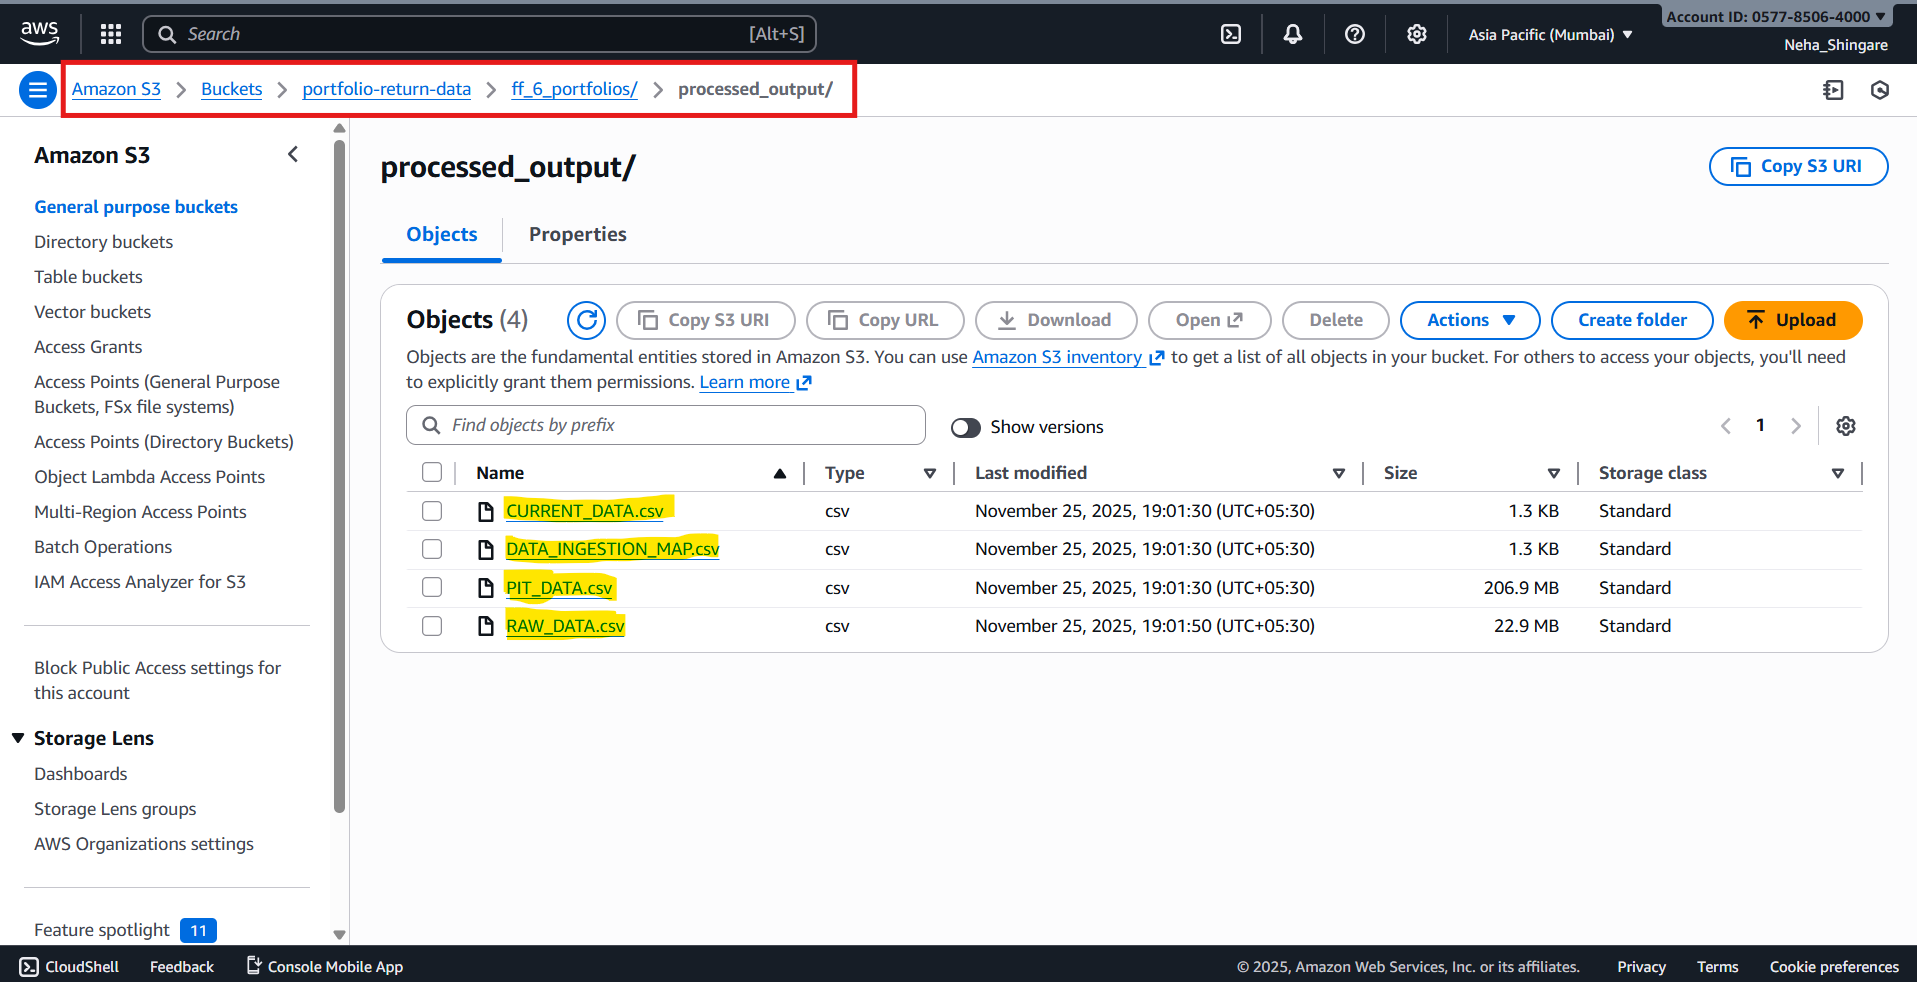

**Reasons for choosing S3:**
- Highly durable.
- Low cost for storing historical datasets.
- Serverless and fully managed.
- Integrates directly with Athena, Redshift Spectrum, Glue, and other AWS analytics services.
- Ideal for a *data lake* pattern where files are append-only and immutable.

**Assumptions / Constraints:**
- Dataset size is small (few MBs).
- Monthly ingestion frequency.
- Low query concurrency.

---

#### 2. AWS Glue Data Catalog — Metadata Layer
Athena uses the Glue Data Catalog to store table definitions for:
- RAW_DATA  
- PIT_DATA  
- CURRENT_DATA  
- DATA_INGESTION_MAP  

This provides schema-on-read capability over files stored in S3.

---

#### 3. Amazon Athena — Query Engine
Athena is used to run SQL queries directly on S3-based datasets without provisioning any servers.
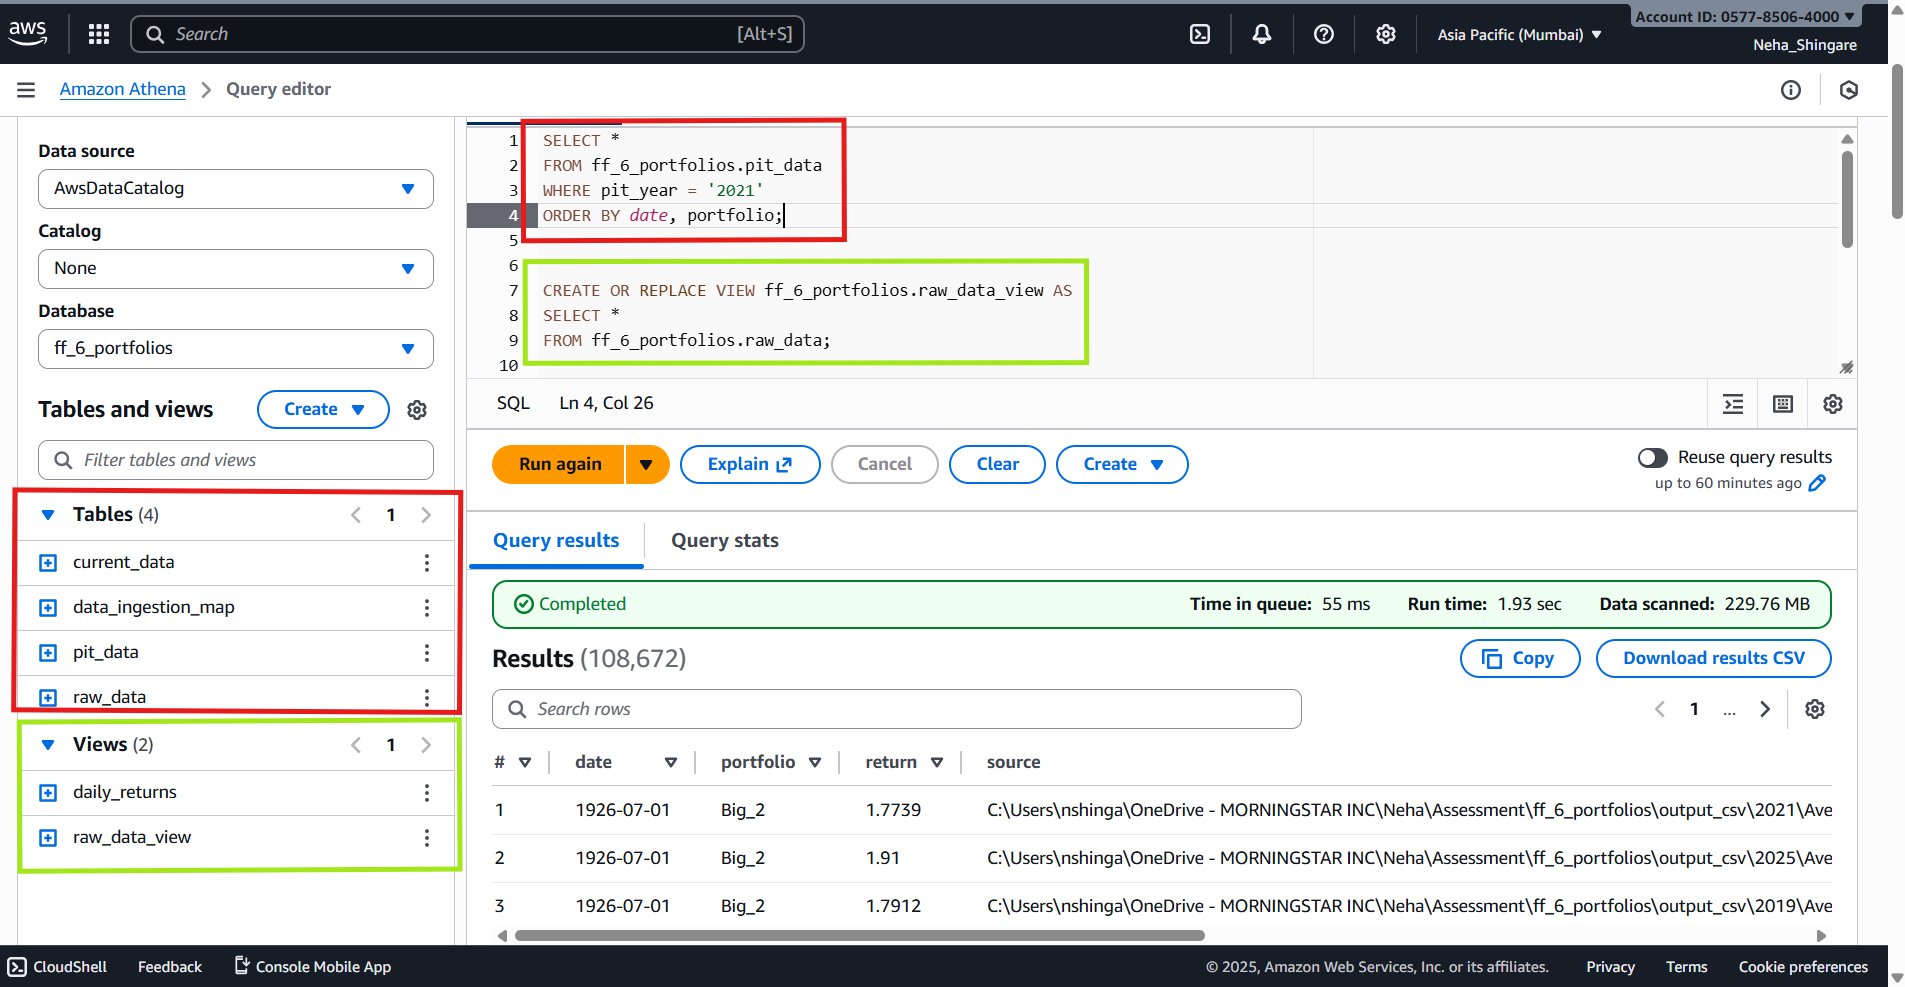
--Tables and athena query in red box, view creation and views in green box

**Reasons for choosing Athena:**
- Serverless: no cluster to manage.
- Pay-per-query: cost-effective for low/medium volumes.
- Perfect for analytical workloads over partitioned, columnar S3 data.
- Automatically scales with the dataset.

**Typical queries run:**
- Validation of RAW_DATA
- Querying PIT and CURRENT datasets
- Quality checks and auditing from the ingestion map

---


### Impact of Scaling Up (Task Takes 25 Minutes or Data Grows 100×)

If ingestion time grows significantly or dataset increases by two orders of magnitude:

#### 1. Switch from CSV to Parquet
- 10–40× reduction in storage size  
- Much faster Athena queries  
- Lower S3 scan cost  

#### 2. Introduce S3 Partitioning
Partition RAW_DATA by: year=<YYYY> / month=<MM>

Athena scans only relevant partitions → major performance improvement.

#### 3. Move ETL to AWS Glue or AWS Lambda
- Glue ETL Jobs for large Spark-style transformations  
- Lambda for lightweight parallel ingestion tasks  

#### 4. Use Workflow Orchestration (AWS Step Functions)
To manage:
Download → Transform → Validate → Upload → Update Metadata

#### 5. Consider Redshift for Heavy / Frequent Queries
If analytics workloads become intensive, migration to Redshift or using Redshift Spectrum is appropriate.


### <u>**Architecture Diagram:**</u>

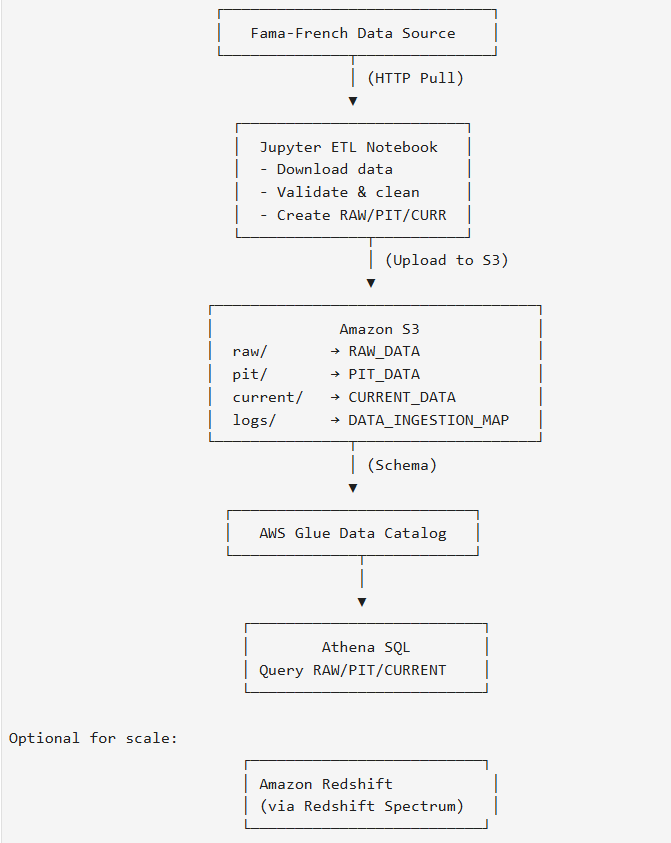

### <u>**Robustness Check:**</u>
    1. Null check
    2. Duplicate check
    3. Schema and dtype validation
    4. Date range validation
    5. Monthly Continuity Check
    6. Portfolio Validation
    7. Return Value Validation
    8. S3 upload check

### <u>**Notes:**</u>

- ***Before running this notebook, please update the AWS configuration by inserting your own Access Key ID and Secret Access Key in the
  aws_access_key_id and aws_secret_access_key variables.***
- Naming conventions followed (`UPPER_CASE` for output tables, snake_case for internal variables)
- Long format for scalability and easier pivoting
- Metadata for traceability (`ingestion_time`, `source_url`, `ingested_by`)
- PIT vs Current for reproducibility vs latest reporting

---

<u>This notebook structure covers:</u> 

- Data ingestion  
- Transformation to long format  
- PIT & current data  
- Source map / metadata  
- Error handling & robustness  
- AWS services & architecture explanation  
- Outputs clearly defined  

---
